In [1]:
using Statistics
using CSV
using DataFrames
using Measures
using Gadfly

ENV["LINES"] = 9;

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly C:\Users\Diego\.julia\packages\Gadfly\09PWZ\src\mapping.jl:228


In [2]:
# parameters
protein = "GRIN2A"

"GRIN2A"

In [3]:
function path_to_TranscriptAnnotation()
    folders = String[]
    for folder in splitpath(pwd())
        push!(folders, folder)
        if folder == "TranscriptAnnotation"
            break
        end
    end
    joinpath(folders...)
end

results_folder = joinpath(path_to_TranscriptAnnotation(), "benchmark", protein)
table_path = joinpath(results_folder, "thoraxe", "homologous_exon_table.csv")

const table = CSV.read(table_path);

## Transcripts per species

In [4]:
by(table, :Species, :TranscriptIDCluster => length ∘ unique) |> 
    df -> rename!(df, :TranscriptIDCluster_function => :Transcripts) |>
    df -> show(df, allcols=true, allrows=true)

9×2 DataFrame
│ Row │ Species                  │ Transcripts │
│     │ String                   │ Int64       │
├─────┼──────────────────────────┼─────────────┤
│ 1   │ bos_taurus               │ 4           │
│ 2   │ homo_sapiens             │ 3           │
│ 3   │ gorilla_gorilla          │ 3           │
│ 4   │ macaca_mulatta           │ 2           │
│ 5   │ mus_musculus             │ 1           │
│ 6   │ ornithorhynchus_anatinus │ 1           │
│ 7   │ rattus_norvegicus        │ 1           │
│ 8   │ sus_scrofa               │ 1           │
│ 9   │ xenopus_tropicalis       │ 1           │

## (Sub)exons without (known) homology

In [5]:
total = sum(startswith(exonid, "0_") for exonid in unique(table[:HomologousExon]))
print("Number of (sub)exons without (known) homology in the gene: ", total)

Number of (sub)exons without (known) homology in the gene: 6

In [6]:
by(table, :Species) do df
    (ExonsWithoutHomology = sum(startswith(exonid, "0_") for exonid in unique(df[:HomologousExon])), )
end |> df -> show(df, allcols=true, allrows=true)

9×2 DataFrame
│ Row │ Species                  │ ExonsWithoutHomology │
│     │ String                   │ Int64                │
├─────┼──────────────────────────┼──────────────────────┤
│ 1   │ bos_taurus               │ 3                    │
│ 2   │ homo_sapiens             │ 1                    │
│ 3   │ gorilla_gorilla          │ 0                    │
│ 4   │ macaca_mulatta           │ 1                    │
│ 5   │ mus_musculus             │ 0                    │
│ 6   │ ornithorhynchus_anatinus │ 0                    │
│ 7   │ rattus_norvegicus        │ 0                    │
│ 8   │ sus_scrofa               │ 0                    │
│ 9   │ xenopus_tropicalis       │ 1                    │

### Short exons

Some subexons doesn't have known homologs because they are too short

In [7]:
by(table, [:TranscriptIDCluster, :ExonIDCluster], :SubexonProteinSequence => join) |>
    df -> by(df, 
        :ExonIDCluster, 
        :SubexonProteinSequence_join => col -> minimum(map(x -> length(replace(x, "*" => "")), col))) |>
    df -> rename!(df, :SubexonProteinSequence_join_function => :ExonLength) |>
    df -> df[df[:ExonLength] .≤ 4, :] |>
    df -> show(df, allcols=true, allrows=true)

3×2 DataFrame
│ Row │ ExonIDCluster      │ ExonLength │
│     │ String             │ Int64      │
├─────┼────────────────────┼────────────┤
│ 1   │ ENSBTAE00000492373 │ 2          │
│ 2   │ ENSBTAE00000523123 │ 3          │
│ 3   │ ENSE00003798867    │ 2          │

## Putative orthologous exons

In [8]:
total = sum(!startswith(exonid, "0_") for exonid in unique(table[:HomologousExon]))
print("Number of putative orthologous exons in the gene: ", total)

Number of putative orthologous exons in the gene: 30

In [9]:
by(table, :Species) do df
    (ExonsWithoutHomology = sum(!startswith(exonid, "0_") for exonid in unique(df[:HomologousExon])), )
end |> df -> show(df, allcols=true, allrows=true)

9×2 DataFrame
│ Row │ Species                  │ ExonsWithoutHomology │
│     │ String                   │ Int64                │
├─────┼──────────────────────────┼──────────────────────┤
│ 1   │ bos_taurus               │ 19                   │
│ 2   │ homo_sapiens             │ 19                   │
│ 3   │ gorilla_gorilla          │ 19                   │
│ 4   │ macaca_mulatta           │ 17                   │
│ 5   │ mus_musculus             │ 17                   │
│ 6   │ ornithorhynchus_anatinus │ 17                   │
│ 7   │ rattus_norvegicus        │ 14                   │
│ 8   │ sus_scrofa               │ 16                   │
│ 9   │ xenopus_tropicalis       │ 19                   │

## Exon Lengths

Distribution of homologous exon lengths

In [10]:
len(x) = ismissing(x) ? 0 : length(x)

const lengths = by(table, :HomologousExon, :HomologousExonSequence => col -> maximum(len.(col))) |> 
    df -> rename!(df, :HomologousExonSequence_function  => :HomologousExonLength ) |>
    df -> sort!(df, :HomologousExon) 

show(lengths, allrows=true)

36×2 DataFrame
│ Row │ HomologousExon │ HomologousExonLength │
│     │ String         │ Int64                │
├─────┼────────────────┼──────────────────────┤
│ 1   │ 0_1            │ 2                    │
│ 2   │ 0_2            │ 3                    │
│ 3   │ 0_3            │ 5                    │
│ 4   │ 0_4            │ 0                    │
│ 5   │ 0_5            │ 0                    │
│ 6   │ 0_6            │ 12                   │
│ 7   │ 10_0           │ 52                   │
│ 8   │ 11_0           │ 46                   │
│ 9   │ 12_0           │ 42                   │
│ 10  │ 13_0           │ 38                   │
│ 11  │ 13_1           │ 7                    │
│ 12  │ 14_0           │ 33                   │
│ 13  │ 15_0           │ 23                   │
│ 14  │ 16_0           │ 21                   │
│ 15  │ 17_0           │ 19                   │
│ 16  │ 18_0           │ 19                   │
│ 17  │ 1_0            │ 396                  │
│ 18  │ 1_1            │ 

In [11]:
lengths[:WithHomologous] = [ !startswith(exonid, "0_") for exonid in lengths[:HomologousExon ] ];

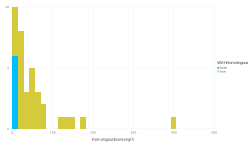

In [12]:
plt = plot(lengths, x="HomologousExonLength", color="WithHomologous", Geom.histogram)
draw(SVG(25cm, 15cm), plt)

## Alternative spliced homologous exons

Exons with a `TranscriptFraction` of `1.0` in a gene are constitutive. The plot can help to identify homologous_exons that change their `TranscriptFraction` in different genes.

In [13]:
constitutive = by(table, :GeneID) do df
    subdf = unique(df[:, [:HomologousExon, :TranscriptsWithSubexon, :TranscriptsInGene]])
    by(subdf, :HomologousExon) do exondf
        (TranscriptFraction = exondf[1, :TranscriptsWithSubexon] / exondf[1, :TranscriptsInGene],
         TranscriptsWithSubexon = exondf[1, :TranscriptsWithSubexon],
         TranscriptsInGene = exondf[1, :TranscriptsInGene])
    end
end;

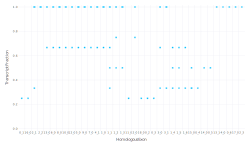

In [14]:
plt = plot(constitutive, x="HomologousExon", y="TranscriptFraction", Geom.point)
draw(SVG(25cm, 15cm), plt)

In [15]:
show(constitutive, allrows=true, allcols=true)

163×5 DataFrame
│ Row │ GeneID             │ HomologousExon │ TranscriptFraction │
│     │ String             │ String         │ Float64            │
├─────┼────────────────────┼────────────────┼────────────────────┤
│ 1   │ ENSBTAG00000007887 │ 0_1            │ 0.25               │
│ 2   │ ENSBTAG00000007887 │ 16_0           │ 0.25               │
│ 3   │ ENSBTAG00000007887 │ 2_1            │ 1.0                │
│ 4   │ ENSBTAG00000007887 │ 2_2            │ 1.0                │
│ 5   │ ENSBTAG00000007887 │ 13_0           │ 1.0                │
│ 6   │ ENSBTAG00000007887 │ 6_0            │ 1.0                │
│ 7   │ ENSBTAG00000007887 │ 8_0            │ 1.0                │
│ 8   │ ENSBTAG00000007887 │ 10_0           │ 1.0                │
│ 9   │ ENSBTAG00000007887 │ 12_0           │ 1.0                │
│ 10  │ ENSBTAG00000007887 │ 5_0            │ 1.0                │
│ 11  │ ENSBTAG00000007887 │ 9_0            │ 1.0                │
│ 12  │ ENSBTAG00000007887 │ 7_0            │ 